# Machine Learning Project - Remaining Useful Life Prediction for Lithium-Ion Battery

### Li-ion Battery Aging Dataset and Prediction of RUL (Using Neural Nets , SVM and Linear Regression)

 A set of four Li-ion batteries (# 5, 6, 7 and 18) were run through 3 different operational profiles
 (charge, discharge and impedance) at room temperature. Charging was carried out in a constant current (CC) 
 mode at 1.5A until the battery voltage reached 4.2V and then continued in a constant voltage (CV) mode until the
 charge current dropped to 20mA. Discharge was carried out at a constant current (CC) level of 2A until the battery
 voltage fell to 2.7V, 2.5V, 2.2V and 2.5V for batteries 5 6 7 and 18 respectively. Impedance measurement was carried 
 out through an electrochemical impedance spectroscopy (EIS) frequency sweep from 0.1Hz to 5kHz. Repeated charge and 
 discharge cycles result in accelerated aging of the batteries while impedance measurements provide insight into the 
 internal battery parameters that change as aging progresses. The experiments were stopped when the batteries reached 
 end-of-life (EOL) criteria, which was a 30% fade in rated capacity (from 2Ahr to 1.4Ahr). This dataset can be used for 
 the prediction of both remaining charge (for a given discharge cycle) and remaining useful life (RUL).


In [1]:
#import libraries
import sys
import scipy
import numpy as np
import matplotlib 
import pandas
import sklearn
#checking versions
print('Python: {}'.format(sys.version))
print('scipy: {}'.format(scipy.__version__))
print('numpy: {}'.format(np.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('pandas: {}'.format(pandas.__version__))
print('sklearn: {}'.format(sklearn.__version__))

Python: 3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]
scipy: 1.4.1
numpy: 1.16.4
matplotlib: 3.1.1
pandas: 0.25.1
sklearn: 0.21.2


## Initial Dataset 

In [3]:
#.mat file processing 
from scipy.io import loadmat
b0005 = loadmat('B0005.mat')
print(b0005.keys())
# print(b0005.get('B0005'))
b0006 = loadmat('B0006.mat')
print(b0006.keys())
b0007 = loadmat('B0007.mat')
print(b0007.keys())

#mdata
mdata1 = b0005['B0005']
mdata2 = b0006['B0006']
mdata3 = b0007['B0007']
#type
mtype1 = mdata1.dtype
print(mtype1)
mtype2 = mdata2.dtype
mtype3 = mdata3.dtype
#ndata
ndata1 = {n: mdata1[n][0,0] for n in mtype1.names}
ndata2 = {n: mdata2[n][0,0] for n in mtype2.names}
ndata3 = {n: mdata3[n][0,0] for n in mtype3.names}
# print(ndata1.items())
# type(ndata)
print(ndata1.keys() , ndata2.keys() ,ndata3.keys() )
print(mtype1.names)

dict_keys(['__header__', '__version__', '__globals__', 'B0005'])
dict_keys(['__header__', '__version__', '__globals__', 'B0006'])
dict_keys(['__header__', '__version__', '__globals__', 'B0007'])
[('cycle', 'O')]
dict_keys(['cycle']) dict_keys(['cycle']) dict_keys(['cycle'])
('cycle',)


## Importing dataset

the .mat file dataset is converted to .csv format. As python does not support .mat dataset.
.mat datasets are generally used in MatLab environment

In [2]:
import pandas as pd
df = pd.read_csv('dataset.csv')
print('shape of the dataset : {}'.format(df.shape))
print(df.loc[10])

shape of the dataset : (636, 7)
Cycle                            2
Capacity(Ah)               1.88066
Voltage Measured(V)        3.06327
Current Measured       -0.00315778
Temperature Measured       37.5081
Time Measured(Sec)         3651.64
SampleId                     B0007
Name: 10, dtype: object


## Preprocess the data

here we check for null values in the dataset, and categorial dataset. 
#### Also we drop the SampleId column from the dataset

In [3]:
# Preprocess the data
df.replace('?',-99999, inplace=True)
print(df.axes)
# Drop feature
df.drop(['SampleId'], 1, inplace=True)

[RangeIndex(start=0, stop=636, step=1), Index(['Cycle', 'Capacity(Ah)', 'Voltage Measured(V)', 'Current Measured',
       'Temperature Measured', 'Time Measured(Sec)', 'SampleId'],
      dtype='object')]


## Checking for null values in the data set

### There are no missing values in the dataset also there are no categorialcal data 

In [12]:
missing_values = (X.isnull().sum())
print(missing_values[missing_values>0])

Series([], dtype: int64)


####  Describe the dataset

Here we can see the total count, mean,std, min, max for all the columns in the dataset

In [7]:
print(df.describe())

            Cycle  Capacity(Ah)  Voltage Measured(V)  Current Measured  \
count  636.000000    636.000000           636.000000        636.000000   
mean    79.764151      1.581652             3.297086         -0.171153   
std     47.137103      0.198765             0.382406          0.556974   
min      0.000000      1.153818             1.813269         -2.012015   
25%     39.000000      1.421123             3.260587         -0.003576   
50%     79.000000      1.559695             3.397571         -0.001903   
75%    119.000000      1.763486             3.529257         -0.000338   
max    167.000000      2.035338             3.697170          0.009113   

       Temperature Measured  Time Measured(Sec)  
count            636.000000          636.000000  
mean              36.318064         3116.977701  
std                2.090171          242.197224  
min               32.113473         2742.843000  
25%               34.639503         2891.996250  
50%               35.808964      

#### There's no categorical data in the dataset 

In [8]:
# Check features type
df.dtypes

Cycle                     int64
Capacity(Ah)            float64
Voltage Measured(V)     float64
Current Measured        float64
Temperature Measured    float64
Time Measured(Sec)      float64
dtype: object

#### Scatter plot matrix shows relation between different feature to one another. 

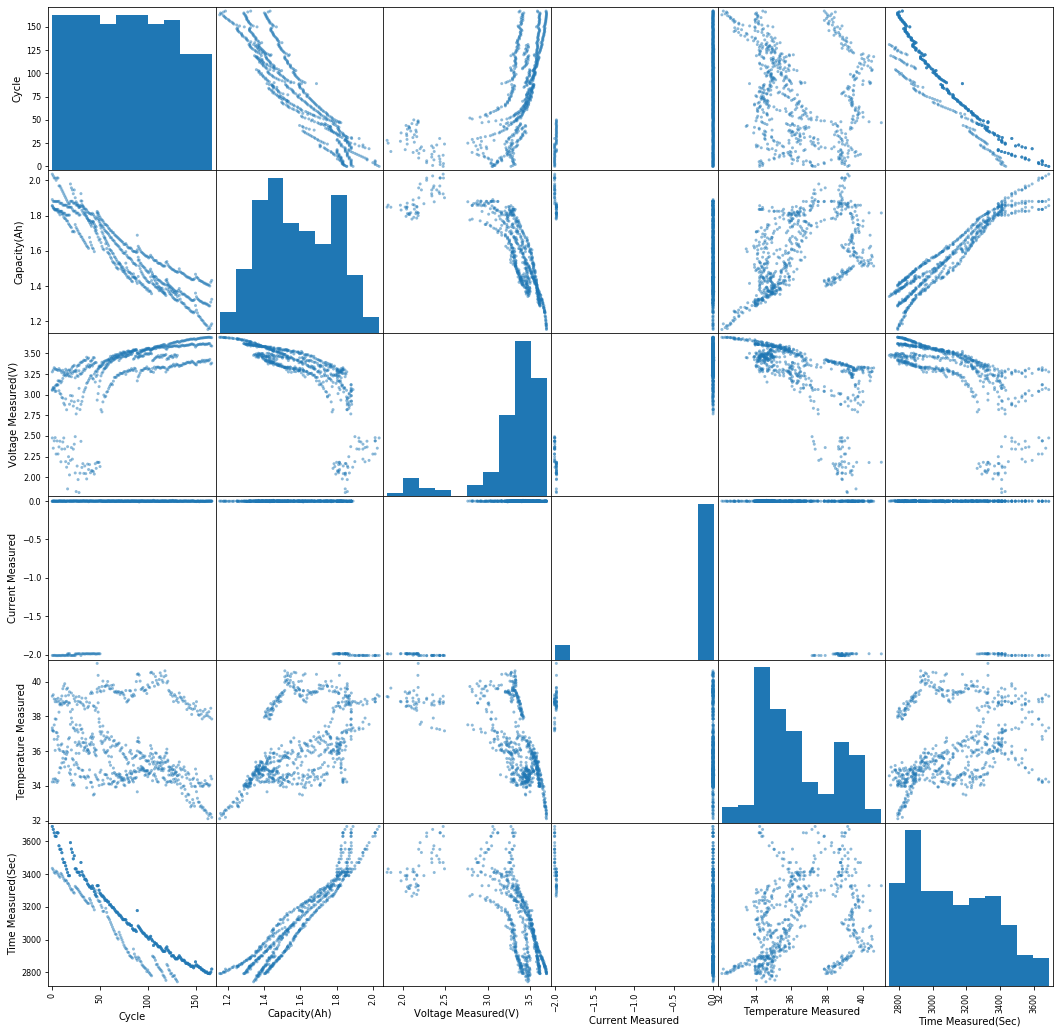

In [10]:
# Create scatter plot matrix
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
scatter_matrix(df, figsize = (18,18))
plt.show()

## Feature extraction


Here we select important features from the dataset for the training

In [11]:
df.head()

,Cycle,Capacity(Ah),Voltage Measured(V),Current Measured,Temperature Measured,Time Measured(Sec)
0,0,1.856487,3.277170,-0.006528,34.230853,3690.234
1,0,2.035338,2.475768,-2.009436,39.162987,3690.234
2,0,1.891052,3.062113,-0.001433,37.338478,3690.234
3,0,1.855005,3.053230,-0.002433,37.205671,3434.891
4,1,1.846327,3.300245,-0.000448,34.392137,3672.344


#### Correlation between the features

We can see that Capacity and Voltage measured are strongly correlated to The target 

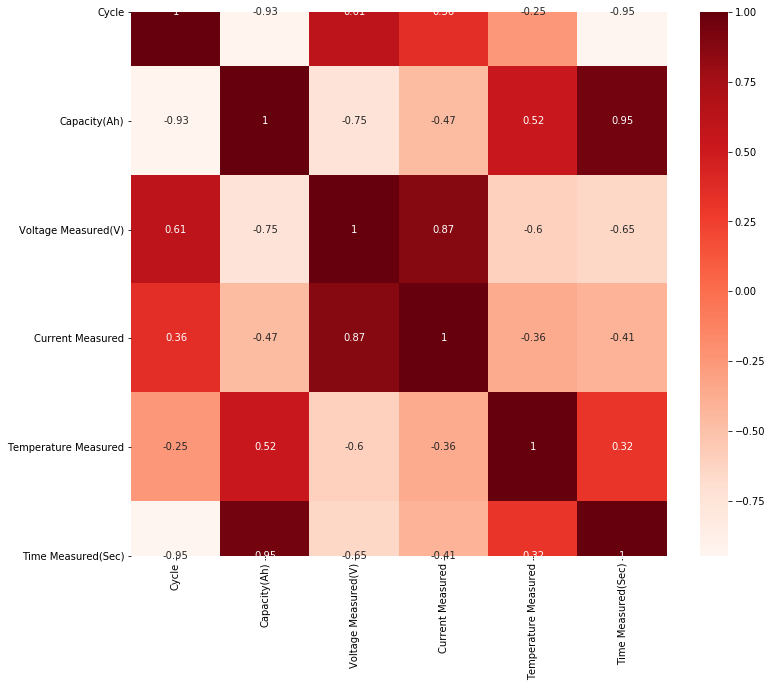

In [12]:
#Using Pearson Correlation
import seaborn as sns
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [13]:
df.columns

Index(['Cycle', 'Capacity(Ah)', 'Voltage Measured(V)', 'Current Measured',
       'Temperature Measured', 'Time Measured(Sec)'],
      dtype='object')

### Selecting the Target and  Features for training 

In [6]:
#divide the dataset

features = ['Cycle','Capacity(Ah)','Voltage Measured(V)','Current Measured','Temperature Measured']

X = df[features]
Y = df['Time Measured(Sec)']

print(X.head())
print("Shape of X {} =".format(X.shape))
print("Shape of Y {} =".format(Y.shape))

   Cycle  Capacity(Ah)  Voltage Measured(V)  Current Measured  \
0      0      1.856487             3.277170         -0.006528   
1      0      2.035338             2.475768         -2.009436   
2      0      1.891052             3.062113         -0.001433   
3      0      1.855005             3.053230         -0.002433   
4      1      1.846327             3.300245         -0.000448   

   Temperature Measured  
0             34.230853  
1             39.162987  
2             37.338478  
3             37.205671  
4             34.392137  
Shape of X (636, 5) =
Shape of Y (636,) =


In [7]:
print(Y[:5])

0    3690.234
1    3690.234
2    3690.234
3    3434.891
4    3672.344
Name: Time Measured(Sec), dtype: float64


## Normalize the data 

Standardize features by removing the mean and scaling to unit variance.

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).

In [8]:
# Normalize the data using sklearn StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
print(scaler)

StandardScaler(copy=True, with_mean=True, with_std=True)


In [9]:
# Transform and display the training data
X_standardized = scaler.transform(X)

data = pd.DataFrame(X_standardized)
data.describe()

,0,1,2,3,4
count,6.360000e+02,6.360000e+02,6.360000e+02,6.360000e+02,6.360000e+02
mean,-1.787529e-16,-3.575058e-16,-4.468822e-17,-6.703233e-17,-1.117206e-15
std,1.000787e+00,1.000787e+00,1.000787e+00,1.000787e+00,1.000787e+00
min,-1.693505e+00,-2.154157e+00,-3.883268e+00,-3.307716e+00,-2.013184e+00
25%,-8.654803e-01,-8.082699e-01,-9.552023e-02,3.011072e-01,-8.037057e-01
50%,-1.622400e-02,-1.105548e-01,2.629765e-01,3.041144e-01,-2.437607e-01
75%,8.330323e-01,9.155417e-01,6.076094e-01,3.069263e-01,1.019492e+00
max,1.852140e+00,2.284324e+00,1.047051e+00,3.239088e-01,2.265653e+00


### Spliting dataset into training and validation set

Here we are spliting up the dataset as the 80% ,20 % ratio.
80% for the training set and 20% data for the validation set.

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_valid = train_test_split(X_standardized,Y,train_size=0.8,test_size=0.2,random_state=0)

## Creating first model → Linear Regression

As we currently have all the data in numeric format. So Linear Regression will run with greater accuracy than
Categorial (object) type data.

In [19]:
from sklearn.linear_model import LinearRegression
model1 = LinearRegression()
model1.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
model1.score(X_val,y_valid)

0.9580456232103931

## Checking the accuracy

Here we are using mean-absolute-error as a primary metric for the checking accuracy of a each model.


In [21]:
from sklearn.metrics import mean_absolute_error
predictions1 = model1.predict(X_val)
score1 = mean_absolute_error(y_valid,predictions1)
score1

36.13652878867846

In [22]:
actual_predicted = pd.DataFrame({'Actual':y_valid, 'Predicted':predictions1})
actual_predicted

,Actual,Predicted
453,2956.406,2888.899562
482,2955.438,2959.027072
516,2882.906,2885.384279
542,2873.453,2894.118019
85,3531.578,3543.953886
...,...,...
336,3067.203,3090.595712
487,2840.016,2934.309986
12,3631.563,3507.528520
412,3020.110,3012.838991


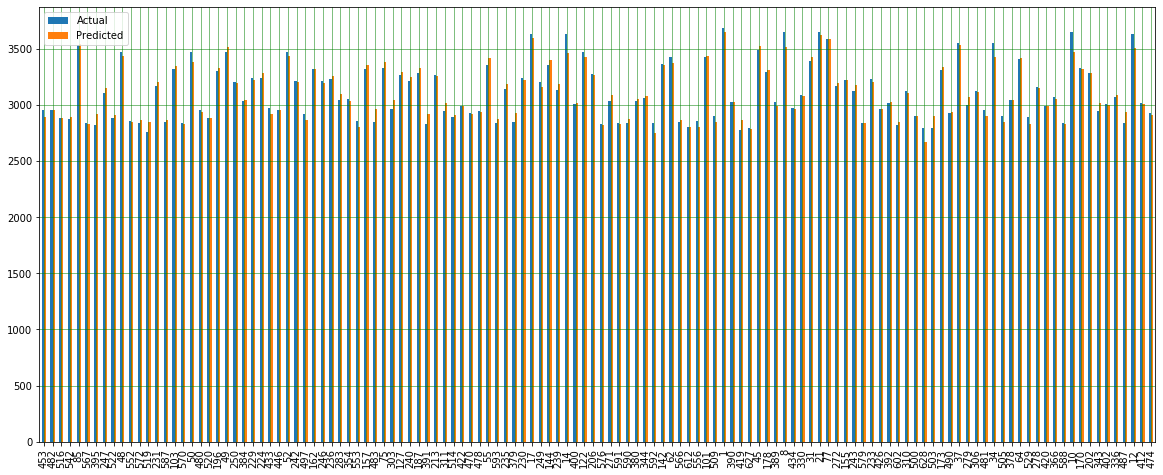

In [23]:
actual_predicted.plot(kind='bar',figsize=(20,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

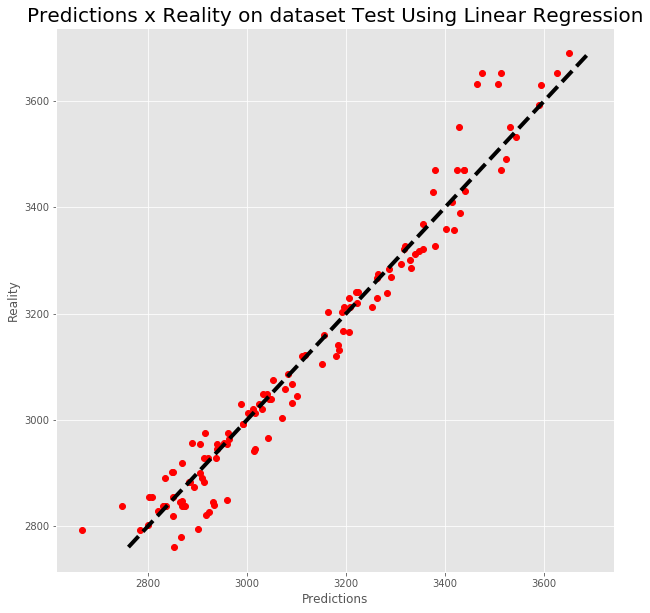

In [24]:
plt.style.use('ggplot')

matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 

fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(predictions1, y_valid, 'ro')
plt.xlabel('Predictions', fontsize = 12)
plt.ylabel('Reality', fontsize=12)
plt.title('Predictions x Reality on dataset Test Using Linear Regression', fontsize = 20)
ax.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=4)
plt.show()

## Creating second model → SVM 

Epsilon-Support Vector Regression.

The implementation is based on libsvm. The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to datasets with more than a couple of 10000 samples

In [25]:
from sklearn.svm import SVR
# most important SVR parameter is Kernel type. It can be linear,polynomial or gaussian SVR. 

model2 = SVR(kernel='linear',gamma='auto')
model2.fit(X_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [26]:
model2.score(X_val,y_valid)

0.9257831840874583

In [27]:
predictions2 = model2.predict(X_val)
score2 = mean_absolute_error(y_valid,predictions2)
score2

44.023475796925815

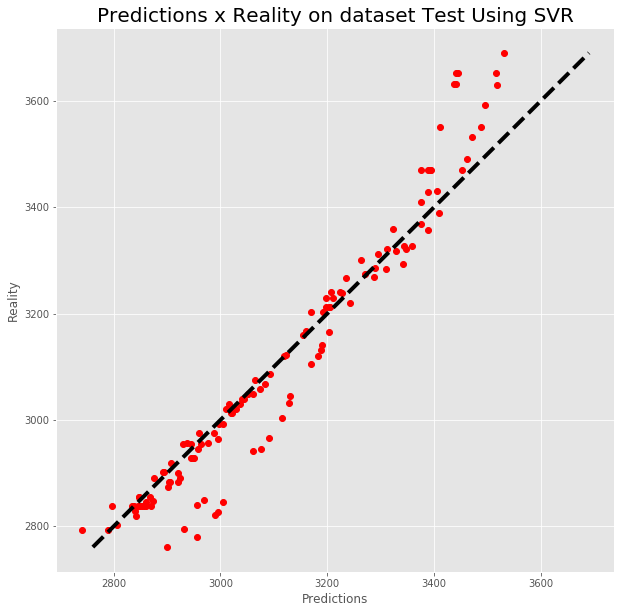

In [28]:
# plt.style.use('ggplot')
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 
#subplots
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(predictions2, y_valid, 'ro')
plt.xlabel('Predictions', fontsize = 12)
plt.ylabel('Reality', fontsize=12)
plt.title('Predictions x Reality on dataset Test Using SVR', fontsize = 20)
ax.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=4)
plt.show()

## Creating Neural Net  → Deep neural net for prediction

Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research.

In [29]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

#neural network 
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1],activation ='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error','accuracy'])
NN_model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               768       
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 165,633
Trainable params: 165,633
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = NN_model.fit(X_train, y_train, validation_data=(X_val, y_valid), epochs=400, verbose=1)

Train on 508 samples, validate on 128 samples
Epoch 1/400
508/508 [==============================] - 0s 163us/step - loss: 23.4014 - mean_absolute_error: 23.4014 - accuracy: 0.0020 - val_loss: 21.4997 - val_mean_absolute_error: 21.4997 - val_accuracy: 0.0000e+00
Epoch 2/400
508/508 [==============================] - 0s 168us/step - loss: 25.7623 - mean_absolute_error: 25.7623 - accuracy: 0.0000e+00 - val_loss: 20.0859 - val_mean_absolute_error: 20.0859 - val_accuracy: 0.0000e+00
Epoch 3/400
508/508 [==============================] - 0s 153us/step - loss: 28.3918 - mean_absolute_error: 28.3918 - accuracy: 0.0000e+00 - val_loss: 24.7735 - val_mean_absolute_error: 24.7735 - val_accuracy: 0.0000e+00
Epoch 4/400
508/508 [==============================] - 0s 129us/step - loss: 25.2058 - mean_absolute_error: 25.2058 - accuracy: 0.0020 - val_loss: 20.4337 - val_mean_absolute_error: 20.4337 - val_accuracy: 0.0000e+00
Epoch 5/400
508/508 [==============================] - 0s 148us/step - loss: 2

Epoch 38/400
508/508 [==============================] - 0s 140us/step - loss: 24.9709 - mean_absolute_error: 24.9709 - accuracy: 0.0000e+00 - val_loss: 19.1900 - val_mean_absolute_error: 19.1900 - val_accuracy: 0.0000e+00
Epoch 39/400
508/508 [==============================] - 0s 126us/step - loss: 24.4998 - mean_absolute_error: 24.4998 - accuracy: 0.0000e+00 - val_loss: 19.8834 - val_mean_absolute_error: 19.8834 - val_accuracy: 0.0078
Epoch 40/400
508/508 [==============================] - 0s 144us/step - loss: 25.0288 - mean_absolute_error: 25.0288 - accuracy: 0.0000e+00 - val_loss: 22.1799 - val_mean_absolute_error: 22.1799 - val_accuracy: 0.0000e+00
Epoch 41/400
508/508 [==============================] - 0s 155us/step - loss: 30.8077 - mean_absolute_error: 30.8077 - accuracy: 0.0039 - val_loss: 26.3817 - val_mean_absolute_error: 26.3817 - val_accuracy: 0.0000e+00
Epoch 42/400
508/508 [==============================] - 0s 142us/step - loss: 26.8292 - mean_absolute_error: 26.8292 - a

Epoch 75/400
508/508 [==============================] - 0s 191us/step - loss: 30.1533 - mean_absolute_error: 30.1533 - accuracy: 0.0000e+00 - val_loss: 25.9995 - val_mean_absolute_error: 25.9995 - val_accuracy: 0.0000e+00
Epoch 76/400
508/508 [==============================] - 0s 234us/step - loss: 27.2533 - mean_absolute_error: 27.2533 - accuracy: 0.0000e+00 - val_loss: 20.6662 - val_mean_absolute_error: 20.6662 - val_accuracy: 0.0000e+00
Epoch 77/400
508/508 [==============================] - 0s 209us/step - loss: 27.3749 - mean_absolute_error: 27.3749 - accuracy: 0.0000e+00 - val_loss: 16.3008 - val_mean_absolute_error: 16.3008 - val_accuracy: 0.0000e+00
Epoch 78/400
508/508 [==============================] - 0s 226us/step - loss: 27.4716 - mean_absolute_error: 27.4716 - accuracy: 0.0000e+00 - val_loss: 21.9676 - val_mean_absolute_error: 21.9676 - val_accuracy: 0.0000e+00
Epoch 79/400
508/508 [==============================] - 0s 195us/step - loss: 28.1173 - mean_absolute_error: 28.

Epoch 112/400
508/508 [==============================] - 0s 177us/step - loss: 25.5502 - mean_absolute_error: 25.5502 - accuracy: 0.0000e+00 - val_loss: 24.3551 - val_mean_absolute_error: 24.3551 - val_accuracy: 0.0000e+00
Epoch 113/400
508/508 [==============================] - 0s 167us/step - loss: 27.2268 - mean_absolute_error: 27.2268 - accuracy: 0.0000e+00 - val_loss: 19.3783 - val_mean_absolute_error: 19.3783 - val_accuracy: 0.0000e+00
Epoch 114/400
508/508 [==============================] - 0s 159us/step - loss: 26.9224 - mean_absolute_error: 26.9224 - accuracy: 0.0020 - val_loss: 30.7031 - val_mean_absolute_error: 30.7031 - val_accuracy: 0.0000e+00
Epoch 115/400
508/508 [==============================] - 0s 163us/step - loss: 24.4783 - mean_absolute_error: 24.4783 - accuracy: 0.0000e+00 - val_loss: 20.6216 - val_mean_absolute_error: 20.6216 - val_accuracy: 0.0000e+00
Epoch 116/400
508/508 [==============================] - 0s 167us/step - loss: 25.3992 - mean_absolute_error: 25

Epoch 185/400
508/508 [==============================] - 0s 193us/step - loss: 21.7144 - mean_absolute_error: 21.7144 - accuracy: 0.0000e+00 - val_loss: 15.6559 - val_mean_absolute_error: 15.6559 - val_accuracy: 0.0000e+00
Epoch 186/400
508/508 [==============================] - 0s 224us/step - loss: 22.7255 - mean_absolute_error: 22.7255 - accuracy: 0.0000e+00 - val_loss: 16.2460 - val_mean_absolute_error: 16.2460 - val_accuracy: 0.0000e+00
Epoch 187/400
508/508 [==============================] - 0s 226us/step - loss: 24.3895 - mean_absolute_error: 24.3895 - accuracy: 0.0000e+00 - val_loss: 26.6558 - val_mean_absolute_error: 26.6558 - val_accuracy: 0.0000e+00
Epoch 188/400
508/508 [==============================] - 0s 297us/step - loss: 26.5032 - mean_absolute_error: 26.5032 - accuracy: 0.0000e+00 - val_loss: 18.5088 - val_mean_absolute_error: 18.5088 - val_accuracy: 0.0078
Epoch 189/400
508/508 [==============================] - 0s 232us/step - loss: 25.9403 - mean_absolute_error: 25

Epoch 258/400
508/508 [==============================] - 0s 173us/step - loss: 26.6884 - mean_absolute_error: 26.6884 - accuracy: 0.0000e+00 - val_loss: 27.7493 - val_mean_absolute_error: 27.7493 - val_accuracy: 0.0000e+00
Epoch 259/400
508/508 [==============================] - 0s 158us/step - loss: 25.4580 - mean_absolute_error: 25.4580 - accuracy: 0.0000e+00 - val_loss: 16.4921 - val_mean_absolute_error: 16.4921 - val_accuracy: 0.0000e+00
Epoch 260/400
508/508 [==============================] - 0s 148us/step - loss: 25.5339 - mean_absolute_error: 25.5339 - accuracy: 0.0000e+00 - val_loss: 20.9929 - val_mean_absolute_error: 20.9929 - val_accuracy: 0.0000e+00
Epoch 261/400
508/508 [==============================] - 0s 151us/step - loss: 26.5086 - mean_absolute_error: 26.5086 - accuracy: 0.0000e+00 - val_loss: 24.2368 - val_mean_absolute_error: 24.2368 - val_accuracy: 0.0000e+00
Epoch 262/400
508/508 [==============================] - 0s 134us/step - loss: 29.0144 - mean_absolute_error

Epoch 295/400
508/508 [==============================] - 0s 298us/step - loss: 23.5184 - mean_absolute_error: 23.5184 - accuracy: 0.0020 - val_loss: 15.2560 - val_mean_absolute_error: 15.2560 - val_accuracy: 0.0000e+00
Epoch 296/400
508/508 [==============================] - 0s 194us/step - loss: 21.7079 - mean_absolute_error: 21.7079 - accuracy: 0.0000e+00 - val_loss: 18.4397 - val_mean_absolute_error: 18.4397 - val_accuracy: 0.0000e+00
Epoch 297/400
508/508 [==============================] - 0s 232us/step - loss: 24.5368 - mean_absolute_error: 24.5368 - accuracy: 0.0000e+00 - val_loss: 17.2576 - val_mean_absolute_error: 17.2576 - val_accuracy: 0.0000e+00
Epoch 298/400
508/508 [==============================] - 0s 203us/step - loss: 21.8017 - mean_absolute_error: 21.8017 - accuracy: 0.0000e+00 - val_loss: 18.9895 - val_mean_absolute_error: 18.9895 - val_accuracy: 0.0000e+00
Epoch 299/400
508/508 [==============================] - 0s 207us/step - loss: 25.3869 - mean_absolute_error: 25

Epoch 332/400
508/508 [==============================] - 0s 191us/step - loss: 35.3827 - mean_absolute_error: 35.3827 - accuracy: 0.0000e+00 - val_loss: 26.9060 - val_mean_absolute_error: 26.9060 - val_accuracy: 0.0000e+00
Epoch 333/400
508/508 [==============================] - 0s 220us/step - loss: 23.6972 - mean_absolute_error: 23.6972 - accuracy: 0.0020 - val_loss: 19.1995 - val_mean_absolute_error: 19.1995 - val_accuracy: 0.0000e+00
Epoch 334/400
508/508 [==============================] - 0s 216us/step - loss: 23.7829 - mean_absolute_error: 23.7829 - accuracy: 0.0000e+00 - val_loss: 20.2280 - val_mean_absolute_error: 20.2280 - val_accuracy: 0.0000e+00
Epoch 335/400
508/508 [==============================] - 0s 248us/step - loss: 24.7415 - mean_absolute_error: 24.7415 - accuracy: 0.0000e+00 - val_loss: 23.2005 - val_mean_absolute_error: 23.2005 - val_accuracy: 0.0000e+00
Epoch 336/400
508/508 [==============================] - 0s 218us/step - loss: 33.7436 - mean_absolute_error: 33

Epoch 369/400
508/508 [==============================] - 0s 215us/step - loss: 27.3697 - mean_absolute_error: 27.3697 - accuracy: 0.0000e+00 - val_loss: 19.9347 - val_mean_absolute_error: 19.9347 - val_accuracy: 0.0000e+00
Epoch 370/400
508/508 [==============================] - 0s 213us/step - loss: 26.0032 - mean_absolute_error: 26.0032 - accuracy: 0.0000e+00 - val_loss: 20.2342 - val_mean_absolute_error: 20.2342 - val_accuracy: 0.0000e+00
Epoch 371/400
508/508 [==============================] - 0s 195us/step - loss: 24.5437 - mean_absolute_error: 24.5437 - accuracy: 0.0000e+00 - val_loss: 28.2986 - val_mean_absolute_error: 28.2986 - val_accuracy: 0.0000e+00
Epoch 372/400
508/508 [==============================] - 0s 215us/step - loss: 33.9612 - mean_absolute_error: 33.9612 - accuracy: 0.0000e+00 - val_loss: 22.5653 - val_mean_absolute_error: 22.5653 - val_accuracy: 0.0000e+00
Epoch 373/400
508/508 [==============================] - 0s 205us/step - loss: 23.6320 - mean_absolute_error

In [33]:
predictions3 = NN_model.predict(X_val)
score3 = mean_absolute_error(y_valid,predictions3)
score3

22.18067732238786

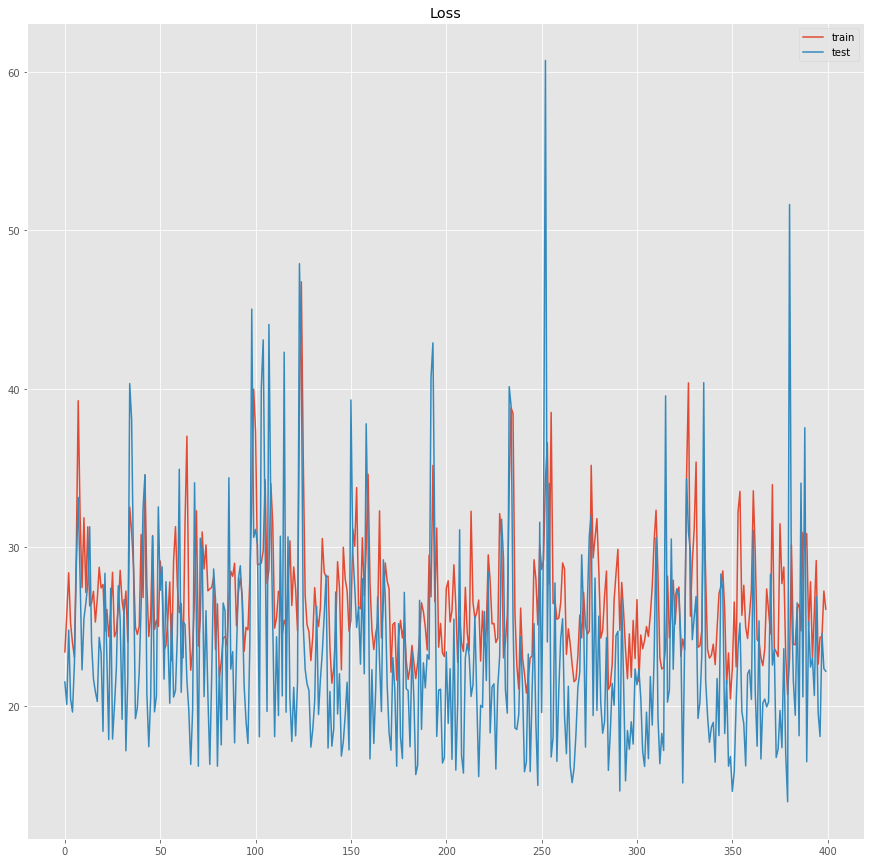

In [34]:
# plot loss during training
import matplotlib.pyplot as pyplot

plt.figure(figsize=(15,15))
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

In [35]:
history.params

{'batch_size': 32,
 'epochs': 400,
 'steps': None,
 'samples': 508,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss',
  'mean_absolute_error',
  'accuracy',
  'val_loss',
  'val_mean_absolute_error',
  'val_accuracy']}

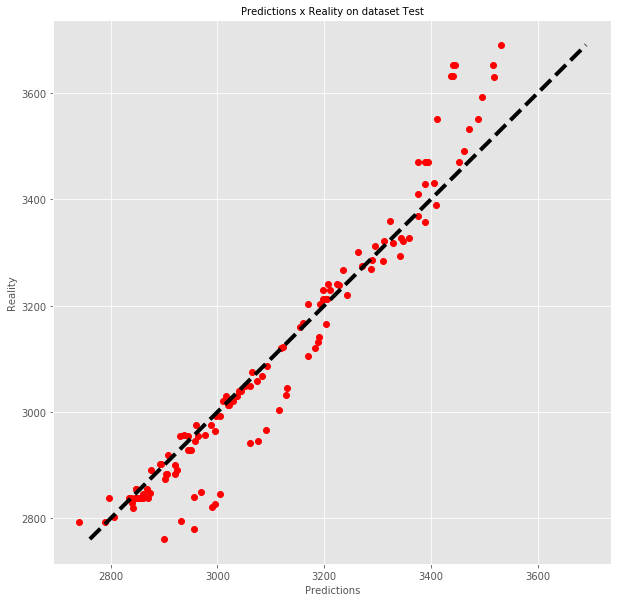

In [36]:
plt.style.use('ggplot')

matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 

fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(predictions2, y_valid, 'ro')
plt.xlabel('Predictions', fontsize = 10)
plt.ylabel('Reality', fontsize=10)
plt.title('Predictions x Reality on dataset Test', fontsize = 10)
ax.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=4)
plt.show()

###  KerasRegressor for improving performance 

To improve the performance of the neural net we shall use sklearn wrapper for keras KerasRegressor .

In [81]:
# define base model
def baseline_model():
    # create model
    NN_model = Sequential()

    # The Input Layer :
    NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1],activation ='relu'))

    # The Hidden Layers :
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

    # The Output Layer :
    NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

    # Compile the network :
    NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error','accuracy'])
    #NN_model.summary()


    return NN_model

In [80]:
X_np =np.asarray(X)
Y_np =np.asarray(Y)

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
     X,Y, test_size=0.2, random_state=0)

from sklearn.preprocessing import MinMaxScaler
scaler =  MinMaxScaler()
X_train_1=scaler.fit_transform(X_train_1)
X_test_1=scaler.fit_transform(X_test_1)

In [113]:
from keras.wrappers.scikit_learn import KerasRegressor

estimator = KerasRegressor(build_fn=baseline_model, epochs=300, batch_size=40, verbose=1)

In [114]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X_train_1, y_train_1, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Epoch 1/300
457/457 [==============================] - 1s 2ms/step - loss: 3117.9902 - mean_absolute_error: 3117.9902 - accuracy: 0.0000e+00
Epoch 2/300
457/457 [==============================] - 0s 289us/step - loss: 3111.7796 - mean_absolute_error: 3111.7795 - accuracy: 0.0000e+00
Epoch 3/300
457/457 [==============================] - 0s 266us/step - loss: 3055.6791 - mean_absolute_error: 3055.6792 - accuracy: 0.0000e+00
Epoch 4/300
457/457 [==============================] - 0s 293us/step - loss: 2734.9774 - mean_absolute_error: 2734.9773 - accuracy: 0.0000e+00
Epoch 5/300
457/457 [==============================] - 0s 278us/step - loss: 1425.2885 - mean_absolute_error: 1425.2886 - accuracy: 0.0000e+00
Epoch 6/300
457/457 [==============================] - 0s 304us/step - loss: 571.0506 - mean_absolute_error: 571.0507 - accuracy: 0.0000e+00
Epoch 7/300
457/457 [==============================] - 0s 289us/step - loss: 392.2490 - mean_absolute_error: 392.2490 - accuracy: 0.0000e+00
Epoch

457/457 [==============================] - 0s 321us/step - loss: 40.9047 - mean_absolute_error: 40.9047 - accuracy: 0.0000e+00
Epoch 118/300
457/457 [==============================] - 0s 312us/step - loss: 39.9956 - mean_absolute_error: 39.9956 - accuracy: 0.0022
Epoch 119/300
457/457 [==============================] - 0s 313us/step - loss: 36.2710 - mean_absolute_error: 36.2710 - accuracy: 0.0000e+00
Epoch 120/300
457/457 [==============================] - 0s 316us/step - loss: 35.9228 - mean_absolute_error: 35.9228 - accuracy: 0.0000e+00
Epoch 121/300
457/457 [==============================] - 0s 318us/step - loss: 41.6593 - mean_absolute_error: 41.6593 - accuracy: 0.0000e+00
Epoch 122/300
457/457 [==============================] - 0s 331us/step - loss: 35.6590 - mean_absolute_error: 35.6590 - accuracy: 0.0000e+00
Epoch 123/300
457/457 [==============================] - 0s 325us/step - loss: 36.4249 - mean_absolute_error: 36.4249 - accuracy: 0.0000e+00
Epoch 124/300
457/457 [========

457/457 [==============================] - 0s 322us/step - loss: 32.0512 - mean_absolute_error: 32.0512 - accuracy: 0.0022
Epoch 234/300
457/457 [==============================] - 0s 397us/step - loss: 32.7528 - mean_absolute_error: 32.7528 - accuracy: 0.0000e+00
Epoch 235/300
457/457 [==============================] - 0s 307us/step - loss: 31.7006 - mean_absolute_error: 31.7006 - accuracy: 0.0022
Epoch 236/300
457/457 [==============================] - 0s 260us/step - loss: 37.7960 - mean_absolute_error: 37.7960 - accuracy: 0.0022
Epoch 237/300
457/457 [==============================] - 0s 340us/step - loss: 36.4249 - mean_absolute_error: 36.4249 - accuracy: 0.0000e+00
Epoch 238/300
457/457 [==============================] - 0s 337us/step - loss: 43.1653 - mean_absolute_error: 43.1653 - accuracy: 0.0022
Epoch 239/300
457/457 [==============================] - 0s 272us/step - loss: 51.7247 - mean_absolute_error: 51.7247 - accuracy: 0.0000e+00
Epoch 240/300
457/457 [====================

457/457 [==============================] - 0s 339us/step - loss: 54.4794 - mean_absolute_error: 54.4794 - accuracy: 0.0000e+00
Epoch 48/300
457/457 [==============================] - 0s 323us/step - loss: 53.1204 - mean_absolute_error: 53.1204 - accuracy: 0.0000e+00
Epoch 49/300
457/457 [==============================] - 0s 335us/step - loss: 54.7346 - mean_absolute_error: 54.7346 - accuracy: 0.0000e+00
Epoch 50/300
457/457 [==============================] - 0s 323us/step - loss: 47.9918 - mean_absolute_error: 47.9918 - accuracy: 0.0000e+00
Epoch 51/300
457/457 [==============================] - 0s 346us/step - loss: 48.8570 - mean_absolute_error: 48.8570 - accuracy: 0.0000e+00
Epoch 52/300
457/457 [==============================] - 0s 310us/step - loss: 47.7705 - mean_absolute_error: 47.7705 - accuracy: 0.0000e+00
Epoch 53/300
457/457 [==============================] - 0s 353us/step - loss: 46.8218 - mean_absolute_error: 46.8218 - accuracy: 0.0000e+00
Epoch 54/300
457/457 [===========

457/457 [==============================] - 0s 287us/step - loss: 41.3765 - mean_absolute_error: 41.3765 - accuracy: 0.0000e+00
Epoch 164/300
457/457 [==============================] - 0s 289us/step - loss: 36.7157 - mean_absolute_error: 36.7157 - accuracy: 0.0022
Epoch 165/300
457/457 [==============================] - 0s 287us/step - loss: 36.6016 - mean_absolute_error: 36.6016 - accuracy: 0.0000e+00
Epoch 166/300
457/457 [==============================] - 0s 291us/step - loss: 37.6889 - mean_absolute_error: 37.6889 - accuracy: 0.0000e+00
Epoch 167/300
457/457 [==============================] - 0s 283us/step - loss: 36.3282 - mean_absolute_error: 36.3282 - accuracy: 0.0000e+00
Epoch 168/300
457/457 [==============================] - 0s 291us/step - loss: 33.4301 - mean_absolute_error: 33.4301 - accuracy: 0.0000e+00
Epoch 169/300
457/457 [==============================] - 0s 289us/step - loss: 37.2155 - mean_absolute_error: 37.2155 - accuracy: 0.0000e+00
Epoch 170/300
457/457 [========

457/457 [==============================] - 0s 377us/step - loss: 35.9603 - mean_absolute_error: 35.9603 - accuracy: 0.0000e+00
Epoch 280/300
457/457 [==============================] - 0s 341us/step - loss: 33.9885 - mean_absolute_error: 33.9885 - accuracy: 0.0000e+00
Epoch 281/300
457/457 [==============================] - 0s 332us/step - loss: 35.0628 - mean_absolute_error: 35.0628 - accuracy: 0.0022
Epoch 282/300
457/457 [==============================] - 0s 309us/step - loss: 31.9083 - mean_absolute_error: 31.9083 - accuracy: 0.0022
Epoch 283/300
457/457 [==============================] - 0s 313us/step - loss: 34.8668 - mean_absolute_error: 34.8668 - accuracy: 0.0000e+00
Epoch 284/300
457/457 [==============================] - 0s 330us/step - loss: 35.1226 - mean_absolute_error: 35.1226 - accuracy: 0.0000e+00
Epoch 285/300
457/457 [==============================] - 0s 294us/step - loss: 32.7622 - mean_absolute_error: 32.7622 - accuracy: 0.0000e+00
Epoch 286/300
457/457 [============

457/457 [==============================] - 0s 298us/step - loss: 45.5842 - mean_absolute_error: 45.5842 - accuracy: 0.0000e+00
Epoch 95/300
457/457 [==============================] - 0s 294us/step - loss: 42.9252 - mean_absolute_error: 42.9252 - accuracy: 0.0000e+00
Epoch 96/300
457/457 [==============================] - 0s 296us/step - loss: 40.4593 - mean_absolute_error: 40.4593 - accuracy: 0.0000e+00
Epoch 97/300
457/457 [==============================] - 0s 322us/step - loss: 42.7218 - mean_absolute_error: 42.7218 - accuracy: 0.0022
Epoch 98/300
457/457 [==============================] - 0s 319us/step - loss: 38.5223 - mean_absolute_error: 38.5223 - accuracy: 0.0022
Epoch 99/300
457/457 [==============================] - 0s 315us/step - loss: 42.7686 - mean_absolute_error: 42.7686 - accuracy: 0.0000e+00
Epoch 100/300
457/457 [==============================] - 0s 298us/step - loss: 50.6235 - mean_absolute_error: 50.6235 - accuracy: 0.0000e+00
Epoch 101/300
457/457 [=================

457/457 [==============================] - 0s 326us/step - loss: 32.9457 - mean_absolute_error: 32.9457 - accuracy: 0.0000e+00
Epoch 211/300
457/457 [==============================] - 0s 304us/step - loss: 35.5631 - mean_absolute_error: 35.5631 - accuracy: 0.0000e+00
Epoch 212/300
457/457 [==============================] - 0s 309us/step - loss: 41.1156 - mean_absolute_error: 41.1156 - accuracy: 0.0000e+00
Epoch 213/300
457/457 [==============================] - 0s 289us/step - loss: 44.1521 - mean_absolute_error: 44.1521 - accuracy: 0.0000e+00
Epoch 214/300
457/457 [==============================] - 0s 289us/step - loss: 32.3306 - mean_absolute_error: 32.3306 - accuracy: 0.0000e+00
Epoch 215/300
457/457 [==============================] - 0s 299us/step - loss: 33.2583 - mean_absolute_error: 33.2583 - accuracy: 0.0000e+00
Epoch 216/300
457/457 [==============================] - 0s 298us/step - loss: 32.4080 - mean_absolute_error: 32.4080 - accuracy: 0.0000e+00
Epoch 217/300
457/457 [====

457/457 [==============================] - 0s 331us/step - loss: 118.6580 - mean_absolute_error: 118.6580 - accuracy: 0.0000e+00
Epoch 25/300
457/457 [==============================] - 0s 318us/step - loss: 116.4820 - mean_absolute_error: 116.4820 - accuracy: 0.0000e+00
Epoch 26/300
457/457 [==============================] - 0s 325us/step - loss: 119.3896 - mean_absolute_error: 119.3896 - accuracy: 0.0000e+00
Epoch 27/300
457/457 [==============================] - 0s 322us/step - loss: 111.2413 - mean_absolute_error: 111.2413 - accuracy: 0.0000e+00
Epoch 28/300
457/457 [==============================] - 0s 302us/step - loss: 105.2708 - mean_absolute_error: 105.2708 - accuracy: 0.0000e+00
Epoch 29/300
457/457 [==============================] - 0s 322us/step - loss: 102.2924 - mean_absolute_error: 102.2923 - accuracy: 0.0000e+00
Epoch 30/300
457/457 [==============================] - 0s 324us/step - loss: 103.7369 - mean_absolute_error: 103.7369 - accuracy: 0.0000e+00
Epoch 31/300
457/45

457/457 [==============================] - 0s 326us/step - loss: 37.6387 - mean_absolute_error: 37.6387 - accuracy: 0.0000e+00
Epoch 141/300
457/457 [==============================] - 0s 308us/step - loss: 37.9846 - mean_absolute_error: 37.9846 - accuracy: 0.0000e+00
Epoch 142/300
457/457 [==============================] - 0s 307us/step - loss: 36.2716 - mean_absolute_error: 36.2716 - accuracy: 0.0000e+00
Epoch 143/300
457/457 [==============================] - 0s 302us/step - loss: 34.1208 - mean_absolute_error: 34.1208 - accuracy: 0.0000e+00
Epoch 144/300
457/457 [==============================] - 0s 307us/step - loss: 39.8490 - mean_absolute_error: 39.8490 - accuracy: 0.0000e+00
Epoch 145/300
457/457 [==============================] - 0s 312us/step - loss: 49.9193 - mean_absolute_error: 49.9193 - accuracy: 0.0022
Epoch 146/300
457/457 [==============================] - 0s 300us/step - loss: 41.6273 - mean_absolute_error: 41.6273 - accuracy: 0.0000e+00
Epoch 147/300
457/457 [========

457/457 [==============================] - 0s 324us/step - loss: 38.8066 - mean_absolute_error: 38.8066 - accuracy: 0.0000e+00
Epoch 257/300
457/457 [==============================] - 0s 313us/step - loss: 32.4444 - mean_absolute_error: 32.4444 - accuracy: 0.0000e+00
Epoch 258/300
457/457 [==============================] - 0s 306us/step - loss: 32.8580 - mean_absolute_error: 32.8580 - accuracy: 0.0000e+00
Epoch 259/300
457/457 [==============================] - 0s 306us/step - loss: 51.0777 - mean_absolute_error: 51.0777 - accuracy: 0.0000e+00
Epoch 260/300
457/457 [==============================] - 0s 313us/step - loss: 42.7701 - mean_absolute_error: 42.7701 - accuracy: 0.0000e+00
Epoch 261/300
457/457 [==============================] - 0s 328us/step - loss: 40.6949 - mean_absolute_error: 40.6949 - accuracy: 0.0000e+00
Epoch 262/300
457/457 [==============================] - 0s 309us/step - loss: 33.1181 - mean_absolute_error: 33.1181 - accuracy: 0.0000e+00
Epoch 263/300
457/457 [====

Epoch 14/300
457/457 [==============================] - 0s 342us/step - loss: 195.8324 - mean_absolute_error: 195.8324 - accuracy: 0.0000e+00
Epoch 15/300
457/457 [==============================] - 0s 321us/step - loss: 184.1411 - mean_absolute_error: 184.1411 - accuracy: 0.0000e+00
Epoch 16/300
457/457 [==============================] - 0s 321us/step - loss: 176.3227 - mean_absolute_error: 176.3227 - accuracy: 0.0000e+00
Epoch 17/300
457/457 [==============================] - 0s 324us/step - loss: 170.0943 - mean_absolute_error: 170.0943 - accuracy: 0.0000e+00
Epoch 18/300
457/457 [==============================] - 0s 326us/step - loss: 178.1257 - mean_absolute_error: 178.1257 - accuracy: 0.0000e+00
Epoch 19/300
457/457 [==============================] - 0s 327us/step - loss: 168.3351 - mean_absolute_error: 168.3351 - accuracy: 0.0000e+00
Epoch 20/300
457/457 [==============================] - 0s 339us/step - loss: 143.6188 - mean_absolute_error: 143.6189 - accuracy: 0.0000e+00
Epoch 

457/457 [==============================] - 0s 346us/step - loss: 35.7372 - mean_absolute_error: 35.7372 - accuracy: 0.0000e+00
Epoch 131/300
457/457 [==============================] - 0s 325us/step - loss: 35.1829 - mean_absolute_error: 35.1829 - accuracy: 0.0022
Epoch 132/300
457/457 [==============================] - 0s 341us/step - loss: 36.4955 - mean_absolute_error: 36.4955 - accuracy: 0.0000e+00
Epoch 133/300
457/457 [==============================] - 0s 346us/step - loss: 38.8771 - mean_absolute_error: 38.8771 - accuracy: 0.0000e+00
Epoch 134/300
457/457 [==============================] - 0s 330us/step - loss: 36.7362 - mean_absolute_error: 36.7362 - accuracy: 0.0000e+00
Epoch 135/300
457/457 [==============================] - 0s 313us/step - loss: 36.0805 - mean_absolute_error: 36.0805 - accuracy: 0.0000e+00
Epoch 136/300
457/457 [==============================] - 0s 310us/step - loss: 37.4959 - mean_absolute_error: 37.4959 - accuracy: 0.0000e+00
Epoch 137/300
457/457 [========

457/457 [==============================] - 0s 326us/step - loss: 36.1189 - mean_absolute_error: 36.1189 - accuracy: 0.0000e+00
Epoch 247/300
457/457 [==============================] - 0s 308us/step - loss: 34.7537 - mean_absolute_error: 34.7537 - accuracy: 0.0000e+00
Epoch 248/300
457/457 [==============================] - 0s 335us/step - loss: 32.4862 - mean_absolute_error: 32.4862 - accuracy: 0.0022
Epoch 249/300
457/457 [==============================] - 0s 348us/step - loss: 32.0778 - mean_absolute_error: 32.0778 - accuracy: 0.0000e+00
Epoch 250/300
457/457 [==============================] - 0s 334us/step - loss: 31.1451 - mean_absolute_error: 31.1451 - accuracy: 0.0000e+00
Epoch 251/300
457/457 [==============================] - 0s 344us/step - loss: 31.2741 - mean_absolute_error: 31.2741 - accuracy: 0.0000e+00
Epoch 252/300
457/457 [==============================] - 0s 351us/step - loss: 33.0974 - mean_absolute_error: 33.0974 - accuracy: 0.0022
Epoch 253/300
457/457 [============

Epoch 4/300
457/457 [==============================] - 0s 352us/step - loss: 2667.8544 - mean_absolute_error: 2667.8545 - accuracy: 0.0000e+00
Epoch 5/300
457/457 [==============================] - 0s 353us/step - loss: 1219.7564 - mean_absolute_error: 1219.7565 - accuracy: 0.0000e+00
Epoch 6/300
457/457 [==============================] - 0s 346us/step - loss: 556.6175 - mean_absolute_error: 556.6176 - accuracy: 0.0000e+00
Epoch 7/300
457/457 [==============================] - 0s 339us/step - loss: 405.4864 - mean_absolute_error: 405.4865 - accuracy: 0.0000e+00
Epoch 8/300
457/457 [==============================] - 0s 348us/step - loss: 336.8870 - mean_absolute_error: 336.8870 - accuracy: 0.0000e+00
Epoch 9/300
457/457 [==============================] - 0s 347us/step - loss: 283.0067 - mean_absolute_error: 283.0067 - accuracy: 0.0000e+00
Epoch 10/300
457/457 [==============================] - 0s 344us/step - loss: 251.2557 - mean_absolute_error: 251.2558 - accuracy: 0.0000e+00
Epoch 11

457/457 [==============================] - 0s 352us/step - loss: 41.9846 - mean_absolute_error: 41.9846 - accuracy: 0.0000e+00
Epoch 120/300
457/457 [==============================] - 0s 346us/step - loss: 40.7953 - mean_absolute_error: 40.7953 - accuracy: 0.0000e+00
Epoch 121/300
457/457 [==============================] - 0s 341us/step - loss: 43.3346 - mean_absolute_error: 43.3346 - accuracy: 0.0000e+00
Epoch 122/300
457/457 [==============================] - 0s 348us/step - loss: 45.0406 - mean_absolute_error: 45.0406 - accuracy: 0.0000e+00
Epoch 123/300
457/457 [==============================] - 0s 361us/step - loss: 55.1764 - mean_absolute_error: 55.1764 - accuracy: 0.0000e+00
Epoch 124/300
457/457 [==============================] - 0s 341us/step - loss: 41.6685 - mean_absolute_error: 41.6685 - accuracy: 0.0022
Epoch 125/300
457/457 [==============================] - 0s 328us/step - loss: 39.3085 - mean_absolute_error: 39.3085 - accuracy: 0.0000e+00
Epoch 126/300
457/457 [========

457/457 [==============================] - 0s 355us/step - loss: 35.5002 - mean_absolute_error: 35.5002 - accuracy: 0.0000e+00
Epoch 236/300
457/457 [==============================] - 0s 350us/step - loss: 38.9883 - mean_absolute_error: 38.9883 - accuracy: 0.0000e+00
Epoch 237/300
457/457 [==============================] - 0s 356us/step - loss: 48.7482 - mean_absolute_error: 48.7482 - accuracy: 0.0022
Epoch 238/300
457/457 [==============================] - 0s 353us/step - loss: 36.6668 - mean_absolute_error: 36.6668 - accuracy: 0.0000e+00
Epoch 239/300
457/457 [==============================] - 0s 348us/step - loss: 41.2141 - mean_absolute_error: 41.2141 - accuracy: 0.0000e+00
Epoch 240/300
457/457 [==============================] - 0s 335us/step - loss: 35.9437 - mean_absolute_error: 35.9436 - accuracy: 0.0000e+00
Epoch 241/300
457/457 [==============================] - 0s 348us/step - loss: 38.5162 - mean_absolute_error: 38.5162 - accuracy: 0.0000e+00
Epoch 242/300
457/457 [========

457/457 [==============================] - 0s 334us/step - loss: 54.6918 - mean_absolute_error: 54.6918 - accuracy: 0.0000e+00
Epoch 51/300
457/457 [==============================] - 0s 328us/step - loss: 58.7070 - mean_absolute_error: 58.7070 - accuracy: 0.0000e+00
Epoch 52/300
457/457 [==============================] - 0s 352us/step - loss: 54.1390 - mean_absolute_error: 54.1390 - accuracy: 0.0000e+00
Epoch 53/300
457/457 [==============================] - 0s 339us/step - loss: 52.6611 - mean_absolute_error: 52.6611 - accuracy: 0.0000e+000s - loss: 52.6992 - mean_absolute_error: 52.6992 - accuracy: 0.0000e+
Epoch 54/300
457/457 [==============================] - 0s 341us/step - loss: 55.7668 - mean_absolute_error: 55.7668 - accuracy: 0.0000e+00
Epoch 55/300
457/457 [==============================] - 0s 337us/step - loss: 55.5339 - mean_absolute_error: 55.5339 - accuracy: 0.0000e+00
Epoch 56/300
457/457 [==============================] - 0s 326us/step - loss: 55.9461 - mean_absolute_e

457/457 [==============================] - 0s 374us/step - loss: 33.1576 - mean_absolute_error: 33.1576 - accuracy: 0.0000e+00
Epoch 167/300
457/457 [==============================] - 0s 339us/step - loss: 34.7533 - mean_absolute_error: 34.7533 - accuracy: 0.0000e+00
Epoch 168/300
457/457 [==============================] - 0s 354us/step - loss: 33.5299 - mean_absolute_error: 33.5299 - accuracy: 0.0000e+00
Epoch 169/300
457/457 [==============================] - 0s 351us/step - loss: 37.8846 - mean_absolute_error: 37.8846 - accuracy: 0.0000e+00
Epoch 170/300
457/457 [==============================] - 0s 339us/step - loss: 34.6963 - mean_absolute_error: 34.6963 - accuracy: 0.0000e+00
Epoch 171/300
457/457 [==============================] - 0s 348us/step - loss: 33.9428 - mean_absolute_error: 33.9428 - accuracy: 0.0000e+00
Epoch 172/300
457/457 [==============================] - 0s 354us/step - loss: 40.3894 - mean_absolute_error: 40.3894 - accuracy: 0.0000e+00
Epoch 173/300
457/457 [====

Epoch 282/300
457/457 [==============================] - 0s 376us/step - loss: 35.8600 - mean_absolute_error: 35.8600 - accuracy: 0.0000e+00
Epoch 283/300
457/457 [==============================] - 0s 332us/step - loss: 40.1923 - mean_absolute_error: 40.1923 - accuracy: 0.0000e+00
Epoch 284/300
457/457 [==============================] - 0s 335us/step - loss: 42.9610 - mean_absolute_error: 42.9610 - accuracy: 0.0000e+00
Epoch 285/300
457/457 [==============================] - 0s 341us/step - loss: 36.1866 - mean_absolute_error: 36.1866 - accuracy: 0.0000e+00
Epoch 286/300
457/457 [==============================] - 0s 348us/step - loss: 37.4376 - mean_absolute_error: 37.4376 - accuracy: 0.0000e+00
Epoch 287/300
457/457 [==============================] - 0s 337us/step - loss: 46.5078 - mean_absolute_error: 46.5078 - accuracy: 0.0000e+00
Epoch 288/300
457/457 [==============================] - 0s 339us/step - loss: 34.2029 - mean_absolute_error: 34.2029 - accuracy: 0.0000e+00
Epoch 289/300

457/457 [==============================] - 0s 400us/step - loss: 41.5770 - mean_absolute_error: 41.5770 - accuracy: 0.0000e+00
Epoch 97/300
457/457 [==============================] - 0s 363us/step - loss: 36.8651 - mean_absolute_error: 36.8651 - accuracy: 0.0000e+00
Epoch 98/300
457/457 [==============================] - 0s 389us/step - loss: 37.8178 - mean_absolute_error: 37.8178 - accuracy: 0.0000e+00
Epoch 99/300
457/457 [==============================] - 0s 370us/step - loss: 41.8526 - mean_absolute_error: 41.8526 - accuracy: 0.0044
Epoch 100/300
457/457 [==============================] - 0s 365us/step - loss: 37.9163 - mean_absolute_error: 37.9163 - accuracy: 0.0000e+00
Epoch 101/300
457/457 [==============================] - 0s 376us/step - loss: 38.8916 - mean_absolute_error: 38.8916 - accuracy: 0.0000e+00
Epoch 102/300
457/457 [==============================] - 0s 369us/step - loss: 39.9974 - mean_absolute_error: 39.9974 - accuracy: 0.0022
Epoch 103/300
457/457 [===============

457/457 [==============================] - 0s 391us/step - loss: 34.1076 - mean_absolute_error: 34.1076 - accuracy: 0.0000e+00
Epoch 212/300
457/457 [==============================] - 0s 379us/step - loss: 36.0301 - mean_absolute_error: 36.0301 - accuracy: 0.0000e+00
Epoch 213/300
457/457 [==============================] - 0s 381us/step - loss: 35.0373 - mean_absolute_error: 35.0373 - accuracy: 0.0000e+00
Epoch 214/300
457/457 [==============================] - 0s 361us/step - loss: 35.6695 - mean_absolute_error: 35.6695 - accuracy: 0.0000e+00
Epoch 215/300
457/457 [==============================] - 0s 371us/step - loss: 35.5825 - mean_absolute_error: 35.5825 - accuracy: 0.0000e+00
Epoch 216/300
457/457 [==============================] - 0s 412us/step - loss: 37.4393 - mean_absolute_error: 37.4393 - accuracy: 0.0000e+00
Epoch 217/300
457/457 [==============================] - 0s 381us/step - loss: 31.5805 - mean_absolute_error: 31.5805 - accuracy: 0.0000e+00
Epoch 218/300
457/457 [====

457/457 [==============================] - 0s 291us/step - loss: 30.0806 - mean_absolute_error: 30.0806 - accuracy: 0.0000e+00
Epoch 270/300
457/457 [==============================] - 0s 291us/step - loss: 30.5973 - mean_absolute_error: 30.5973 - accuracy: 0.0022
Epoch 271/300
457/457 [==============================] - 0s 300us/step - loss: 32.8856 - mean_absolute_error: 32.8856 - accuracy: 0.0022
Epoch 272/300
457/457 [==============================] - 0s 284us/step - loss: 33.1361 - mean_absolute_error: 33.1361 - accuracy: 0.0022
Epoch 273/300
457/457 [==============================] - 0s 291us/step - loss: 32.1870 - mean_absolute_error: 32.1870 - accuracy: 0.0000e+00
Epoch 274/300
457/457 [==============================] - 0s 289us/step - loss: 34.2764 - mean_absolute_error: 34.2764 - accuracy: 0.0000e+00
Epoch 275/300
457/457 [==============================] - 0s 291us/step - loss: 38.0105 - mean_absolute_error: 38.0105 - accuracy: 0.0000e+00
Epoch 276/300
457/457 [================

458/458 [==============================] - 0s 391us/step - loss: 41.1354 - mean_absolute_error: 41.1354 - accuracy: 0.0000e+00
Epoch 85/300
458/458 [==============================] - 0s 405us/step - loss: 42.8697 - mean_absolute_error: 42.8697 - accuracy: 0.0000e+00
Epoch 86/300
458/458 [==============================] - 0s 362us/step - loss: 40.7289 - mean_absolute_error: 40.7289 - accuracy: 0.0000e+00
Epoch 87/300
458/458 [==============================] - 0s 373us/step - loss: 36.0010 - mean_absolute_error: 36.0010 - accuracy: 0.0000e+00
Epoch 88/300
458/458 [==============================] - 0s 391us/step - loss: 36.8704 - mean_absolute_error: 36.8704 - accuracy: 0.0000e+00
Epoch 89/300
458/458 [==============================] - 0s 390us/step - loss: 44.0224 - mean_absolute_error: 44.0224 - accuracy: 0.0022
Epoch 90/300
458/458 [==============================] - 0s 367us/step - loss: 38.2280 - mean_absolute_error: 38.2280 - accuracy: 0.0000e+00
Epoch 91/300
458/458 [===============

Epoch 142/300
458/458 [==============================] - 0s 345us/step - loss: 35.0406 - mean_absolute_error: 35.0406 - accuracy: 0.0000e+00
Epoch 143/300
458/458 [==============================] - 0s 354us/step - loss: 33.1736 - mean_absolute_error: 33.1736 - accuracy: 0.0000e+00
Epoch 144/300
458/458 [==============================] - 0s 336us/step - loss: 34.7094 - mean_absolute_error: 34.7094 - accuracy: 0.0022
Epoch 145/300
458/458 [==============================] - 0s 356us/step - loss: 37.5351 - mean_absolute_error: 37.5351 - accuracy: 0.0000e+00
Epoch 146/300
458/458 [==============================] - 0s 343us/step - loss: 35.0696 - mean_absolute_error: 35.0696 - accuracy: 0.0000e+00
Epoch 147/300
458/458 [==============================] - 0s 332us/step - loss: 42.8227 - mean_absolute_error: 42.8227 - accuracy: 0.0000e+00
Epoch 148/300
458/458 [==============================] - 0s 340us/step - loss: 40.5209 - mean_absolute_error: 40.5209 - accuracy: 0.0000e+00
Epoch 149/300
458

458/458 [==============================] - 0s 419us/step - loss: 29.6369 - mean_absolute_error: 29.6369 - accuracy: 0.0000e+00
Epoch 257/300
458/458 [==============================] - 0s 463us/step - loss: 32.6994 - mean_absolute_error: 32.6994 - accuracy: 0.0000e+00
Epoch 258/300
458/458 [==============================] - 0s 433us/step - loss: 30.1084 - mean_absolute_error: 30.1084 - accuracy: 0.0000e+00
Epoch 259/300
458/458 [==============================] - 0s 388us/step - loss: 32.7604 - mean_absolute_error: 32.7604 - accuracy: 0.0000e+00
Epoch 260/300
458/458 [==============================] - 0s 404us/step - loss: 35.6391 - mean_absolute_error: 35.6391 - accuracy: 0.0000e+00
Epoch 261/300
458/458 [==============================] - 0s 402us/step - loss: 38.7456 - mean_absolute_error: 38.7456 - accuracy: 0.0000e+00
Epoch 262/300
458/458 [==============================] - 0s 393us/step - loss: 39.9136 - mean_absolute_error: 39.9136 - accuracy: 0.0000e+00
Epoch 263/300
458/458 [====

458/458 [==============================] - 0s 390us/step - loss: 46.5222 - mean_absolute_error: 46.5222 - accuracy: 0.0000e+00
Epoch 71/300
458/458 [==============================] - 0s 362us/step - loss: 43.6884 - mean_absolute_error: 43.6884 - accuracy: 0.0022
Epoch 72/300
458/458 [==============================] - 0s 343us/step - loss: 44.1890 - mean_absolute_error: 44.1890 - accuracy: 0.0000e+00
Epoch 73/300
458/458 [==============================] - 0s 419us/step - loss: 50.3054 - mean_absolute_error: 50.3054 - accuracy: 0.0000e+00
Epoch 74/300
458/458 [==============================] - 0s 410us/step - loss: 43.6545 - mean_absolute_error: 43.6545 - accuracy: 0.0000e+00
Epoch 75/300
458/458 [==============================] - 0s 381us/step - loss: 49.5628 - mean_absolute_error: 49.5628 - accuracy: 0.0000e+00
Epoch 76/300
458/458 [==============================] - 0s 404us/step - loss: 40.7509 - mean_absolute_error: 40.7509 - accuracy: 0.0000e+00
Epoch 77/300
458/458 [===============

Epoch 128/300
458/458 [==============================] - 0s 334us/step - loss: 37.4895 - mean_absolute_error: 37.4895 - accuracy: 0.0000e+00
Epoch 129/300
458/458 [==============================] - 0s 354us/step - loss: 37.9069 - mean_absolute_error: 37.9069 - accuracy: 0.0000e+00
Epoch 130/300
458/458 [==============================] - 0s 405us/step - loss: 37.8719 - mean_absolute_error: 37.8719 - accuracy: 0.0000e+00
Epoch 131/300
458/458 [==============================] - 0s 336us/step - loss: 40.5582 - mean_absolute_error: 40.5582 - accuracy: 0.0000e+00
Epoch 132/300
458/458 [==============================] - 0s 349us/step - loss: 40.7031 - mean_absolute_error: 40.7031 - accuracy: 0.0022
Epoch 133/300
458/458 [==============================] - 0s 336us/step - loss: 37.6755 - mean_absolute_error: 37.6755 - accuracy: 0.0000e+00
Epoch 134/300
458/458 [==============================] - 0s 355us/step - loss: 36.0828 - mean_absolute_error: 36.0828 - accuracy: 0.0022
Epoch 135/300
458/458

458/458 [==============================] - 0s 314us/step - loss: 33.4508 - mean_absolute_error: 33.4508 - accuracy: 0.0000e+00
Epoch 242/300
458/458 [==============================] - 0s 306us/step - loss: 35.3275 - mean_absolute_error: 35.3275 - accuracy: 0.0022
Epoch 243/300
458/458 [==============================] - 0s 314us/step - loss: 34.4549 - mean_absolute_error: 34.4549 - accuracy: 0.0000e+00
Epoch 244/300
458/458 [==============================] - 0s 312us/step - loss: 35.2109 - mean_absolute_error: 35.2109 - accuracy: 0.0000e+00
Epoch 245/300
458/458 [==============================] - 0s 315us/step - loss: 39.5345 - mean_absolute_error: 39.5345 - accuracy: 0.0022
Epoch 246/300
458/458 [==============================] - 0s 310us/step - loss: 36.4825 - mean_absolute_error: 36.4825 - accuracy: 0.0000e+00
Epoch 247/300
458/458 [==============================] - 0s 314us/step - loss: 37.5995 - mean_absolute_error: 37.5995 - accuracy: 0.0000e+00
Epoch 248/300
458/458 [============

In [115]:
history=estimator.fit(X_train_1,y_train_1)

Epoch 1/300
508/508 [==============================] - 1s 2ms/step - loss: 3117.9737 - mean_absolute_error: 3117.9736 - accuracy: 0.0000e+00
Epoch 2/300
508/508 [==============================] - 0s 404us/step - loss: 3105.7144 - mean_absolute_error: 3105.7144 - accuracy: 0.0000e+00
Epoch 3/300
508/508 [==============================] - 0s 392us/step - loss: 2994.2479 - mean_absolute_error: 2994.2478 - accuracy: 0.0000e+00
Epoch 4/300
508/508 [==============================] - 0s 364us/step - loss: 2352.1158 - mean_absolute_error: 2352.1160 - accuracy: 0.0000e+00
Epoch 5/300
508/508 [==============================] - 0s 368us/step - loss: 763.3477 - mean_absolute_error: 763.3477 - accuracy: 0.0000e+00
Epoch 6/300
508/508 [==============================] - 0s 379us/step - loss: 421.3762 - mean_absolute_error: 421.3762 - accuracy: 0.0000e+00
Epoch 7/300
508/508 [==============================] - 0s 382us/step - loss: 348.8564 - mean_absolute_error: 348.8564 - accuracy: 0.0000e+00
Epoch 8

508/508 [==============================] - 0s 402us/step - loss: 49.6561 - mean_absolute_error: 49.6561 - accuracy: 0.0020
Epoch 118/300
508/508 [==============================] - 0s 372us/step - loss: 39.1768 - mean_absolute_error: 39.1768 - accuracy: 0.0000e+00
Epoch 119/300
508/508 [==============================] - 0s 393us/step - loss: 36.9170 - mean_absolute_error: 36.9170 - accuracy: 0.0000e+00
Epoch 120/300
508/508 [==============================] - 0s 388us/step - loss: 43.6935 - mean_absolute_error: 43.6935 - accuracy: 0.0000e+00
Epoch 121/300
508/508 [==============================] - 0s 372us/step - loss: 38.6911 - mean_absolute_error: 38.6911 - accuracy: 0.0000e+00
Epoch 122/300
508/508 [==============================] - 0s 374us/step - loss: 38.6778 - mean_absolute_error: 38.6778 - accuracy: 0.0000e+00
Epoch 123/300
508/508 [==============================] - 0s 399us/step - loss: 38.5988 - mean_absolute_error: 38.5988 - accuracy: 0.0000e+00
Epoch 124/300
508/508 [========

508/508 [==============================] - 0s 392us/step - loss: 35.4762 - mean_absolute_error: 35.4762 - accuracy: 0.0000e+00
Epoch 233/300
508/508 [==============================] - 0s 388us/step - loss: 41.7923 - mean_absolute_error: 41.7923 - accuracy: 0.0000e+00
Epoch 234/300
508/508 [==============================] - 0s 429us/step - loss: 41.8668 - mean_absolute_error: 41.8668 - accuracy: 0.0000e+000s - loss: 43.8939 - mean_absolute_error: 43.8939 - accuracy: 0.0000e+
Epoch 235/300
508/508 [==============================] - 0s 413us/step - loss: 33.2448 - mean_absolute_error: 33.2448 - accuracy: 0.0000e+00
Epoch 236/300
508/508 [==============================] - 0s 459us/step - loss: 35.4602 - mean_absolute_error: 35.4602 - accuracy: 0.0000e+00
Epoch 237/300
508/508 [==============================] - 0s 443us/step - loss: 35.4391 - mean_absolute_error: 35.4391 - accuracy: 0.0000e+00
Epoch 238/300
508/508 [==============================] - 0s 397us/step - loss: 36.9200 - mean_abso

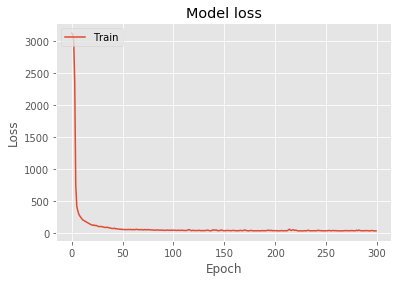

In [116]:
plt.plot(history.history['loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [117]:
from sklearn.metrics import accuracy_score
prediction = estimator.predict(X_test_1)

128/128 [==============================] - 2s 15ms/step


In [118]:
estimator.score(X_test_1,y_test_1)

128/128 [==============================] - 1s 6ms/step


-35.45308780670166

In [119]:
print('MAE ',mean_absolute_error(y_test_1,prediction))

MAE  35.453077011108576


In [120]:
from sklearn.metrics import r2_score
print("r_square score: ", r2_score(y_test_1,prediction))

r_square score:  0.9596002207503137


In [121]:
train_error =  np.abs(y_test_1 - prediction)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)

In [122]:
print("std_error: ",std_error)
print("mean_error: ",mean_error)
print("min_error: ",min_error)
print("max_error: ",max_error)

std_error:  35.38386816943473
mean_error:  35.453077011108576
min_error:  0.13294921875012733
max_error:  171.43518945312462


128/128 [==============================] - 0s 180us/step


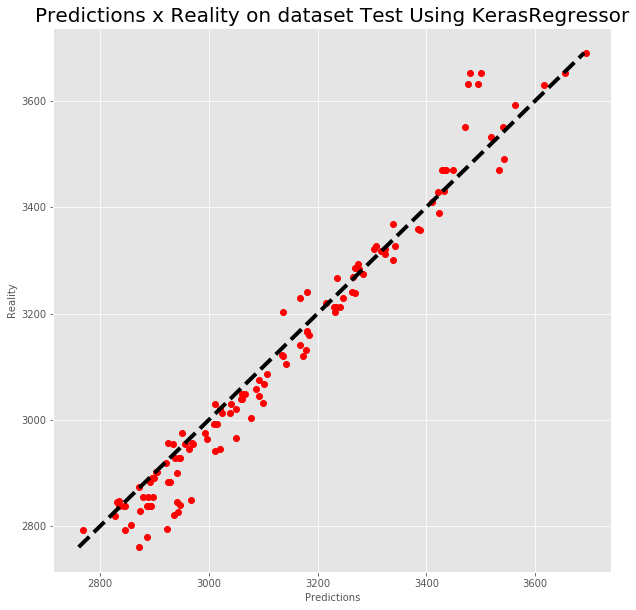

In [123]:
preds4 = estimator.predict(X_test_1)

plt.style.use('ggplot')
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 

fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(preds4, y_valid, 'ro')
plt.xlabel('Predictions', fontsize = 10)
plt.ylabel('Reality', fontsize=10)
plt.title('Predictions x Reality on dataset Test Using KerasRegressor', fontsize = 20)
ax.plot([y_test_1.min(), y_test_1.max()], [y_test_1.min(), y_test_1.max()], 'k--', lw=4)
plt.show()

## RandomForest

RandomForestRegressor is generally best suited for the regression type of problems in ML. We shall add one to check it works better than Neuralnet 

MAE = 21 minimal error in all the models.

In [72]:
from sklearn.ensemble import RandomForestRegressor

model2 = RandomForestRegressor(n_estimators=100,random_state=0,criterion='mae',max_depth=10)
model2.fit(X_train,y_train)
model2.score(X_val,y_valid)

0.991053127839923

In [73]:
#making the predictions
prediction4 = model2.predict(X_val)

In [74]:
mean_absolute_error(y_valid,prediction4)

14.808303906250103

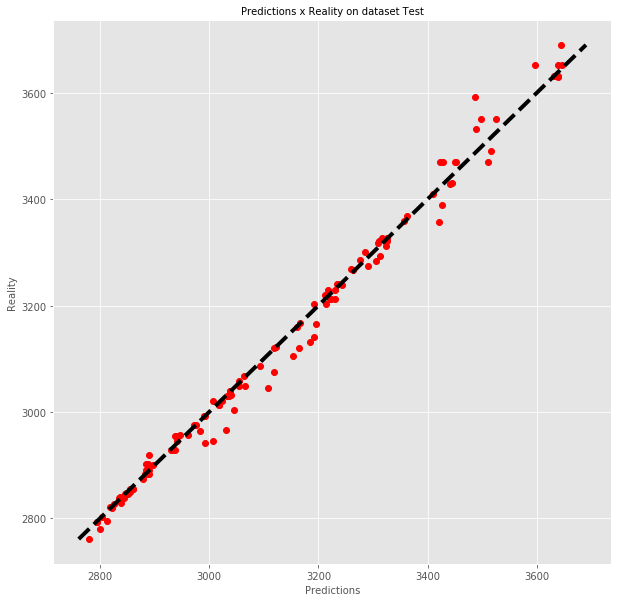

In [75]:
plt.style.use('ggplot')
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 

fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(prediction4, y_valid, 'ro')
plt.xlabel('Predictions', fontsize = 10)
plt.ylabel('Reality', fontsize=10)
plt.title('Predictions x Reality on dataset Test', fontsize = 10)
ax.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=4)
plt.show()

In [76]:
from xgboost import XGBRegressor

model5 = XGBRegressor(n_estimators=500,learning_rate=0.01)
model5.fit(X_train_1,y_train_1,early_stopping_rounds=5, eval_set=[(X_test_1,y_test_1)],verbose=True )

# model5.fit(X_train_1,y_train_1)

[21:20:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3088.9
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:3058.12
[2]	validation_0-rmse:3027.75
[3]	validation_0-rmse:2997.57
[4]	validation_0-rmse:2967.8
[5]	validation_0-rmse:2938.22
[6]	validation_0-rmse:2909.05
[7]	validation_0-rmse:2880.11
[8]	validation_0-rmse:2851.5
[9]	validation_0-rmse:2823.09
[10]	validation_0-rmse:2794.98
[11]	validation_0-rmse:2767.21


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12]	validation_0-rmse:2739.69
[13]	validation_0-rmse:2712.49
[14]	validation_0-rmse:2685.49
[15]	validation_0-rmse:2658.73
[16]	validation_0-rmse:2632.32
[17]	validation_0-rmse:2606.11
[18]	validation_0-rmse:2580.23
[19]	validation_0-rmse:2554.61
[20]	validation_0-rmse:2529.18
[21]	validation_0-rmse:2504.07
[22]	validation_0-rmse:2479.14
[23]	validation_0-rmse:2454.52
[24]	validation_0-rmse:2430.1
[25]	validation_0-rmse:2405.91
[26]	validation_0-rmse:2382
[27]	validation_0-rmse:2358.36
[28]	validation_0-rmse:2334.96
[29]	validation_0-rmse:2311.72
[30]	validation_0-rmse:2288.75
[31]	validation_0-rmse:2266.04
[32]	validation_0-rmse:2243.49
[33]	validation_0-rmse:2221.2
[34]	validation_0-rmse:2199.2
[35]	validation_0-rmse:2177.37
[36]	validation_0-rmse:2155.71
[37]	validation_0-rmse:2134.3
[38]	validation_0-rmse:2113.16
[39]	validation_0-rmse:2092.2
[40]	validation_0-rmse:2071.42
[41]	validation_0-rmse:2050.91
[42]	validation_0-rmse:2030.61
[43]	validation_0-rmse:2010.41
[44]	validation_

[272]	validation_0-rmse:215.132
[273]	validation_0-rmse:213.13
[274]	validation_0-rmse:211.139
[275]	validation_0-rmse:209.211
[276]	validation_0-rmse:207.26
[277]	validation_0-rmse:205.329
[278]	validation_0-rmse:203.452
[279]	validation_0-rmse:201.56
[280]	validation_0-rmse:199.688
[281]	validation_0-rmse:197.898
[282]	validation_0-rmse:196.071
[283]	validation_0-rmse:194.291
[284]	validation_0-rmse:192.493
[285]	validation_0-rmse:190.714
[286]	validation_0-rmse:189.003
[287]	validation_0-rmse:187.256
[288]	validation_0-rmse:185.531
[289]	validation_0-rmse:183.879
[290]	validation_0-rmse:182.221
[291]	validation_0-rmse:180.572
[292]	validation_0-rmse:178.939
[293]	validation_0-rmse:177.354
[294]	validation_0-rmse:175.768
[295]	validation_0-rmse:174.18
[296]	validation_0-rmse:172.626
[297]	validation_0-rmse:171.074
[298]	validation_0-rmse:169.54
[299]	validation_0-rmse:168.05
[300]	validation_0-rmse:166.529
[301]	validation_0-rmse:165.054
[302]	validation_0-rmse:163.58
[303]	validatio

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [77]:
pred5 = model5.predict(X_test_1)
score5 = mean_absolute_error(y_test_1,pred5)
score5

31.894299362182426

In [78]:
model5.score(X_test_1,y_test_1)

0.9715032410711822

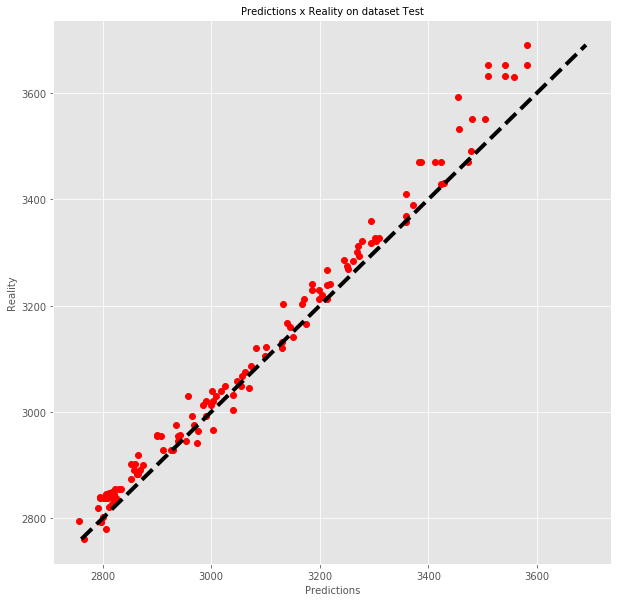

In [79]:
pred5 = model5.predict(X_test_1)
plt.style.use('ggplot')

matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 

fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(pred5, y_test_1, 'ro')
plt.xlabel('Predictions', fontsize = 10)
plt.ylabel('Reality', fontsize=10)
plt.title('Predictions x Reality on dataset Test', fontsize = 10)
ax.plot([y_test_1.min(), y_test_1.max()], [y_test_1.min(), y_test_1.max()], 'k--', lw=4)
plt.show()

## Conclusion and Findings

### Data preprocessing:
    
    Dataset did not have any missing values. So we did not have to handle them separately .
    Approches for Missing values = Dropping them or Imputer Approch (mean values or most
    frequent values in the dataset) There are not categorical('object' type) columns in 
    the dataset.
    Approches for Categorical Data = We can simply drop them if they did not influence the 
    target.Or we can use OneHotEncoding or LabelEncoder to convert them . 
    All the columns are of numeric type. Due to the numerical types of columns we can use 
    all the features to predict the           target.
    
    To preprocess the data sklearn has very important class called as StandardScalar which
    normalize the data.
    
### Data Visualization :

    Using correlation, We can see that Capacity and Voltage measured are strongly 
    correlated to The target.  
    Also after every model definition and MAE score calculation the graph shows 
    that how the model is predicting the values respect to actual values.

### Model Definition :
    
    First the model is the Linear Regression model. As the all the data is of 
    numeric type this model predicts the target values with greater accuracy.
    We can see the score 0.95. MAE score of the model is 36. 
    Second model is SVM ( Support vector machine) . There are two types of 
    the classifiers in sklearn.svm namely SVC, SVR . 
    SVC is used for classification and SVR is used for the Regression Problems.
    As we get higher accuracy in Linear regression .we selected the kernel type 
    to 'linear' for SVR. which gives the score upto 0.92 and 
    MAE score of the model is 44.
    
#### Neural net :
   
    We designed neural net with the Dense layers . We compiled the model based 
    on loss metric as MAE. Epochs are set to 300 and Earlier when the epochs are
    set 200 the MAE score was 43 very nearly. So As the Epochs are increased the 
    Accuracy of the neural net also increased. So the MAE score of the Neural net 
    is 22. You can see the graphs that neaural net is predicting the target values 
    with greater accuracy. MAE score of neural net is less than Both the models.
    
    KerasRegressor is the wrapper for Keras neural nets by sklearn. It uses the 
    neural net defined by keras and wraps into sklearn model. After training it gives 
    the MAE score of 31.
    
### Models Designed Specifically for Regression Problems :
    
    Even if the highly trained neural net There are certain models in Sklearn which 
    specifically used for Regression problems.RandomForestRegressor is one of them.
    It has score of 0.99 and lowest MAE score which is 14 i.e. this model 
    making less errors than that of the neural net itself. Last model is XBG
    i.e. Extreame Gradient Boosting .This model also performs well in Regression 
    problems . XGBRegressor gives the score of .97 and gives MAE score of 0.31